In [ ]:
# Sample_QA_Takagi_FDR2024
# 2024-11-05 K. Takagi et al.

# Sample code for solving an advection diffusion equation on a quantum annealer (Takagi et al., Fluid Dyn. Res. 2024).
# Code author: Kenichiro Takagi (Keio University; currently at The University of Tokyo)
# Annotation editor: Koji Fukagata (Keio University)

# Authors provide no guarantees for this code.  Use as-is and for academic research use only; no commercial use allowed without permission. For citations, please use the reference below:
## Ref: K. Takagi, N. Moriya, S. Aoki, K. Endo, M. Muramatsu, and K. Fukagata, 
##     "Implementation of spectral methods on Ising machines: toward flow simulations on quantum annealers,"
##      Fluid Dyn. Res. (2024), https://doi.org/10.1088/1873-7005/ad8d09
# -- version 1: November 05, 2024

In [1]:
import numpy as np
import numba
from matplotlib import pyplot as plt
import json
import uuid
import subprocess as sb
import os
import math
from matplotlib.animation import ArtistAnimation
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.animation as animation
import pathlib
import tqdm
import random
from amplify import Solver
from amplify import FixstarsClient
from amplify import BinarySymbolGenerator
from amplify import DWaveSamplerClient
from amplify import LeapHybridSamplerClient
from amplify import VariableGenerator
from amplify import Model,solve
#===================Font setting======================#
plt.rc('font',**{'family':'sans-serif','sans-serif':['Times New Roman']})
plt.rc('text', usetex=True)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rc('font', family='Times New Roman')
#==================================================#

In [2]:
#====================#
# Setting Parameters #
#====================#

posM = 15   # Number of grid points when solving with FDM (excluding the end points)
posN = 6    # Expansion order + 1 in Chebyshev spectral method (CSM). For instance, N=5 results in 4th order expansion.
n = 8       # Number of binary bits used of a quantity
maxs = 1.5  # Upper limit value
mins = -0.5 # Lower limit value
root = 2    # The weight of each bit is expressed as a power of this "root". 
            ## Setting this to 1 results in simple summation (see, e.g., Endo et al., 2022)
plotN = 30  # Number of points used for error calculation in CSM as well as for plotting the figure．
            ## The condition plotN > posN is sufficient due to the nature of Clenshaw-Curtis quadrature.

a=1         # Diffision coefficient
u=1         # Flow velocity
sL=0        # Left boundary condition (Dirichlet)
sR=1        # Right boundary condition (Dirichlet)

rep = 5     # Number of repetitions of computation

### "Fixstars Amplify AE" ###
tFAAE = "*** Paste your own token here ***"
timeout = 1000 # Actual time spent for a single annealing [ms]．

### "D-Wave Sampler" ###
tDS = "*** Paste your own token here ***"
slvname = "Advantage_system4.1" # Name of the solver
numread = 100 # Number of reads
anntime = 20  # Annealing time [$\mu$ s]. (The default is likely ca 20 $\mu$s.)

### "Leap Hybrid Solver" ###
tLHS = "*** Paste your own token here ***"
slvnm = "hybrid_binary_quadratic_model_version2p" # Name of the solver
tlimit = 3 # Time limit for the sum of classical and quantum computations [s]

whichsolver = "Fixstars Amplify AE" # Which of the above solvers is used?

# Setting the weights for QUBO bits
eps = np.zeros(n)
widt = maxs-mins

if root==1:
    for i in range(n):
        eps[i]=widt/n
else:
    for i in range(n):
        eps[i]=(root**i)*widt*(root-1)/(root**n-1)

Pe=u/a # Peclet number
print('Peclet Number is',Pe)

Peclet Number is 1.0


In [3]:
#======================================#
# Computation of matrix components A,b #
#======================================#

gP=u/((posM+1)*a)

Af = np.zeros((posM,posM)) # Components for FDM
for i in range(posM-1):
    Af[i,i+1]=2-gP
    Af[i+1,i]=2+gP
for i in range(posM):
    Af[i,i]=-4

Ac = np.zeros([posN,posN]) # Components for CSM
for i in range(posN):
    if i%2 == 1:
        Ac[0,i]-=2*u*i
    else:
        Ac[0,i]+=2*a*i*i*i
for i in range(posN-2):
    k = i+1
    for j in range(k+1, posN):
        if j%2 == k%2:
            Ac[k,j]+=4*a*j*(j**2-k**2)
        else:
            Ac[k,j]-=4*u*j

m=0
for i in range(posN):
    for j in range(posN):
        m += Ac[i,j]
m /= (posN*posN)

rightw=m
leftw=m

for i in range(posN):
    Ac[posN-2,i]=1*rightw
    Ac[posN-1,i]=((-1)**i)*leftw

# print(Af)
# print(Ac)

bf = np.zeros(posM)
bf[0]=-(2+gP)*sL
bf[posM-1]=-(2-gP)*sR
for i in range(posM):
    for j in range(posM):
        bf[i]-=Af[i,j]*mins

bc = np.zeros(posN)
for i in range(posN):
    for j in range(posN):
        bc[i]-=Ac[i,j]*mins
bc[posN-2]+=sR*rightw
bc[posN-1]+=sL*leftw

[[-4.      1.9375  0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [ 2.0625 -4.      1.9375  0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      2.0625 -4.      1.9375  0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      2.0625 -4.      1.9375  0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      2.0625 -4.      1.9375  0.      0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      2.0625 -4.      1.9375  0.      0.
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      2.0625 -4.      1.9375  0.
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      2.0625 -4.      1.9375
   0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0

In [4]:
def getH(A,b,H2,H1): # Obtaining Hamiltonian H2 (2nd orderterm) and H1 (1st order term) from A and b
    pos = len(b)
    AtA = np.zeros([pos,pos])
    btA = np.zeros(pos)

    # calc AtA and btA

    for i in range(pos):
        for j in range(pos):
            for k in range(pos):
                AtA[i,j] += A[k,i]*A[k,j]
    
    for i in range(pos):
        for j in range(pos):
            btA[i] += b[j]*A[j,i]
    
    #setting the Hamiltonian using AtA and btA
    
    for i in range(pos):
        for j in range(pos):
            for c1 in range(n):
                for c2 in range(n):
                    H2[n*i+c1,n*j+c2] += eps[c1] * eps[c2] * AtA[i,j]
    for i in range(pos):
        for c in range(n):
            H1[n*i+c] -= 2 * eps[c] * btA[i]
    
    return 1

def decode(stepres,pos): # Converting binary data to real numbers
    coA = np.zeros(pos)
    stepres = stepres.reshape(pos,n)
    for i in range(pos):
        for j in range(n):
            coA[i]+=stepres[i,j]*eps[j]
        coA[i]+=mins
    return coA

def clencurt(x,w,N): # Clenshaw-Curtis quadrature
    theta = np.zeros(N)
    v = np.ones(N-2)
    for i in range(N):
        theta[i] = i * np.pi / (N-1)
        x[i] = np.cos(theta[i])
    if N%2==1:
        w[0] = 1/((N-1)**2-1)
        w[N-1] = 1/((N-1)**2-1)
        for k in tqdm.tqdm(range((N-1)//2-1)):
            for i in range(1,(N-1)):
                v[i-1] -= 2 * np.cos(2*(k+1)*theta[i])/(4*((k+1)**2)-1)
        for i in range(1,(N-1)):
            v[i-1] -= np.cos((N-1) * theta[i])/((N-1)**2-1)
    else:
        w[0] = 1/(N-1)**2
        w[(N-1)] = 1/(N-1)**2
        for k in tqdm.tqdm(range(((N-1)-1)//2)):
            for i in range(1,(N-1)):
                v[i-1] -= 2 * np.cos(2*(k+1)*theta[i])/(4*((k+1)**2)-1)
    for i in tqdm.tqdm(range(1,(N-1))):
        w[i]=2*v[i-1]/(N-1)
    return 1

In [5]:
def Dotask(H2,H1):

    if whichsolver=="D-Wave Sampler":
        client = DWaveSamplerClient()
        client.token = tDS
        client.solver = slvname
        client.parameters.num_reads = numread
        client.parameters.annealing_time = anntime
    elif whichsolver=="Leap Hybrid Solver":
        client = LeapHybridSamplerClient()
        client.token = tLHS
        client.solver = slvnm
        client.parameters.time_limit = tlimit
    else:
        client = FixstarsClient()
        client.token = tFAAE
        client.parameters.timeout = timeout
    
    gen = VariableGenerator()
    mat = gen.matrix("Binary", shape=len(H1))
    mat.quadratic = H2
    mat.linear = H1
    q = mat.variable_array
    model = Model(mat)
    result = solve(model, client)
    return q.evaluate(result.best.values)

In [6]:
xf = np.zeros(posM+2)
yf = np.zeros([rep,posM+2])
ef = np.zeros(posM+2)
for i in range(posM+2):
    xf[i]=i/(posM+1)

xc = np.zeros(plotN)
yc = np.zeros([rep,plotN])
ec = np.zeros(plotN)
weigh = np.zeros(plotN)
clencurt(xc,weigh,plotN)
for i in range(plotN):
    xc[i]=0.5*xc[i]+0.5
xc=np.flipud(xc)
T = np.zeros([posN,posN]) # Chebyshev coefficients
T[0,0]=1
T[1,1]=1
for i in range(2,posN):
    T[i,0]-=T[i-2,0]
    for j in range(1,i+1):
        T[i,j]=2*T[i-1,j-1]-T[i-2,j]

eplotx=np.zeros(plotN+posM)
eploty=np.zeros(plotN+posM)
nf=1
nc=0

for i in range(plotN+posM):
    if nf>=posM+1:
        eplotx[nf+nc-1]=xc[nc]
        nc=nc+1
    elif nc>=plotN+1:
        eplotx[nf+nc-1]=xf[nf]
        nf=nf+1
    elif xf[nf]<=xc[nc]:
        eplotx[nf+nc-1]=xf[nf]
        nf=nf+1
    else:
        eplotx[nf+nc-1]=xc[nc]
        nc=nc+1

for i in range(posM+2):
    ef[i]=sL+((math.exp(Pe*xf[i])-1)/(math.exp(Pe)-1))*(sR-sL)
for i in range(plotN):
    ec[i]=sL+((math.exp(Pe*xc[i])-1)/(math.exp(Pe)-1))*(sR-sL)    
for i in range(plotN+posM):
    eploty[i]=sL+((math.exp(Pe*eplotx[i])-1)/(math.exp(Pe)-1))*(sR-sL)

100%|██████████| 28/28 [00:00<?, ?it/s]


In [7]:
# Computation with FDM
H2 = np.zeros([posM*n,posM*n])
H1 = np.zeros([posM*n])
getH(Af,bf,H2,H1)
msef = 0
for l in tqdm.tqdm(range(rep)):
    ans = Dotask(H2,H1)
    coAf = decode(ans,posM)
    yf[l,0] = sL
    yf[l,posM+1] = sR
    for i in range(posM):
        yf[l,i+1] = coAf[i]
    for i in range(posM+1):
        msef += ((yf[l,i]-ef[i])**2+(yf[l,i+1]-ef[i+1])**2)/(2*(posM+1))
msef /= rep

# Computation with CSM
H2 = np.zeros([posN*n,posN*n])
H1 = np.zeros([posN*n])
getH(Ac,bc,H2,H1)
msec = 0
for l in tqdm.tqdm(range(rep)):
    ans = Dotask(H2,H1)
    coAc = decode(ans,posN)
    for i in range(plotN):
        for j in range(posN):
            for k in range(j+1):
                yc[l,i] += coAc[j]*T[j,k]*((2*xc[i]-1)**(k))
    for i in range(plotN):
        msec += ((yc[l,i]-ec[i])**2)*weigh[i]/2
msec /= rep

UUID = uuid.uuid4()
filename1 = f'QA_FDM_n_{n}_posM_{posM}_sL_{sL}_sR_{sR}_u_{u}_a_{a}_{rep}_{whichsolver}_{UUID}.npy'
filename2 = f'QA_CSM_n_{n}_posN_{posN}_sL_{sL}_sR_{sR}_u_{u}_a_{a}_{rep}_{whichsolver}_{UUID}.npy'
np.save(filename1, yf)
np.save(filename2, yc)

100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


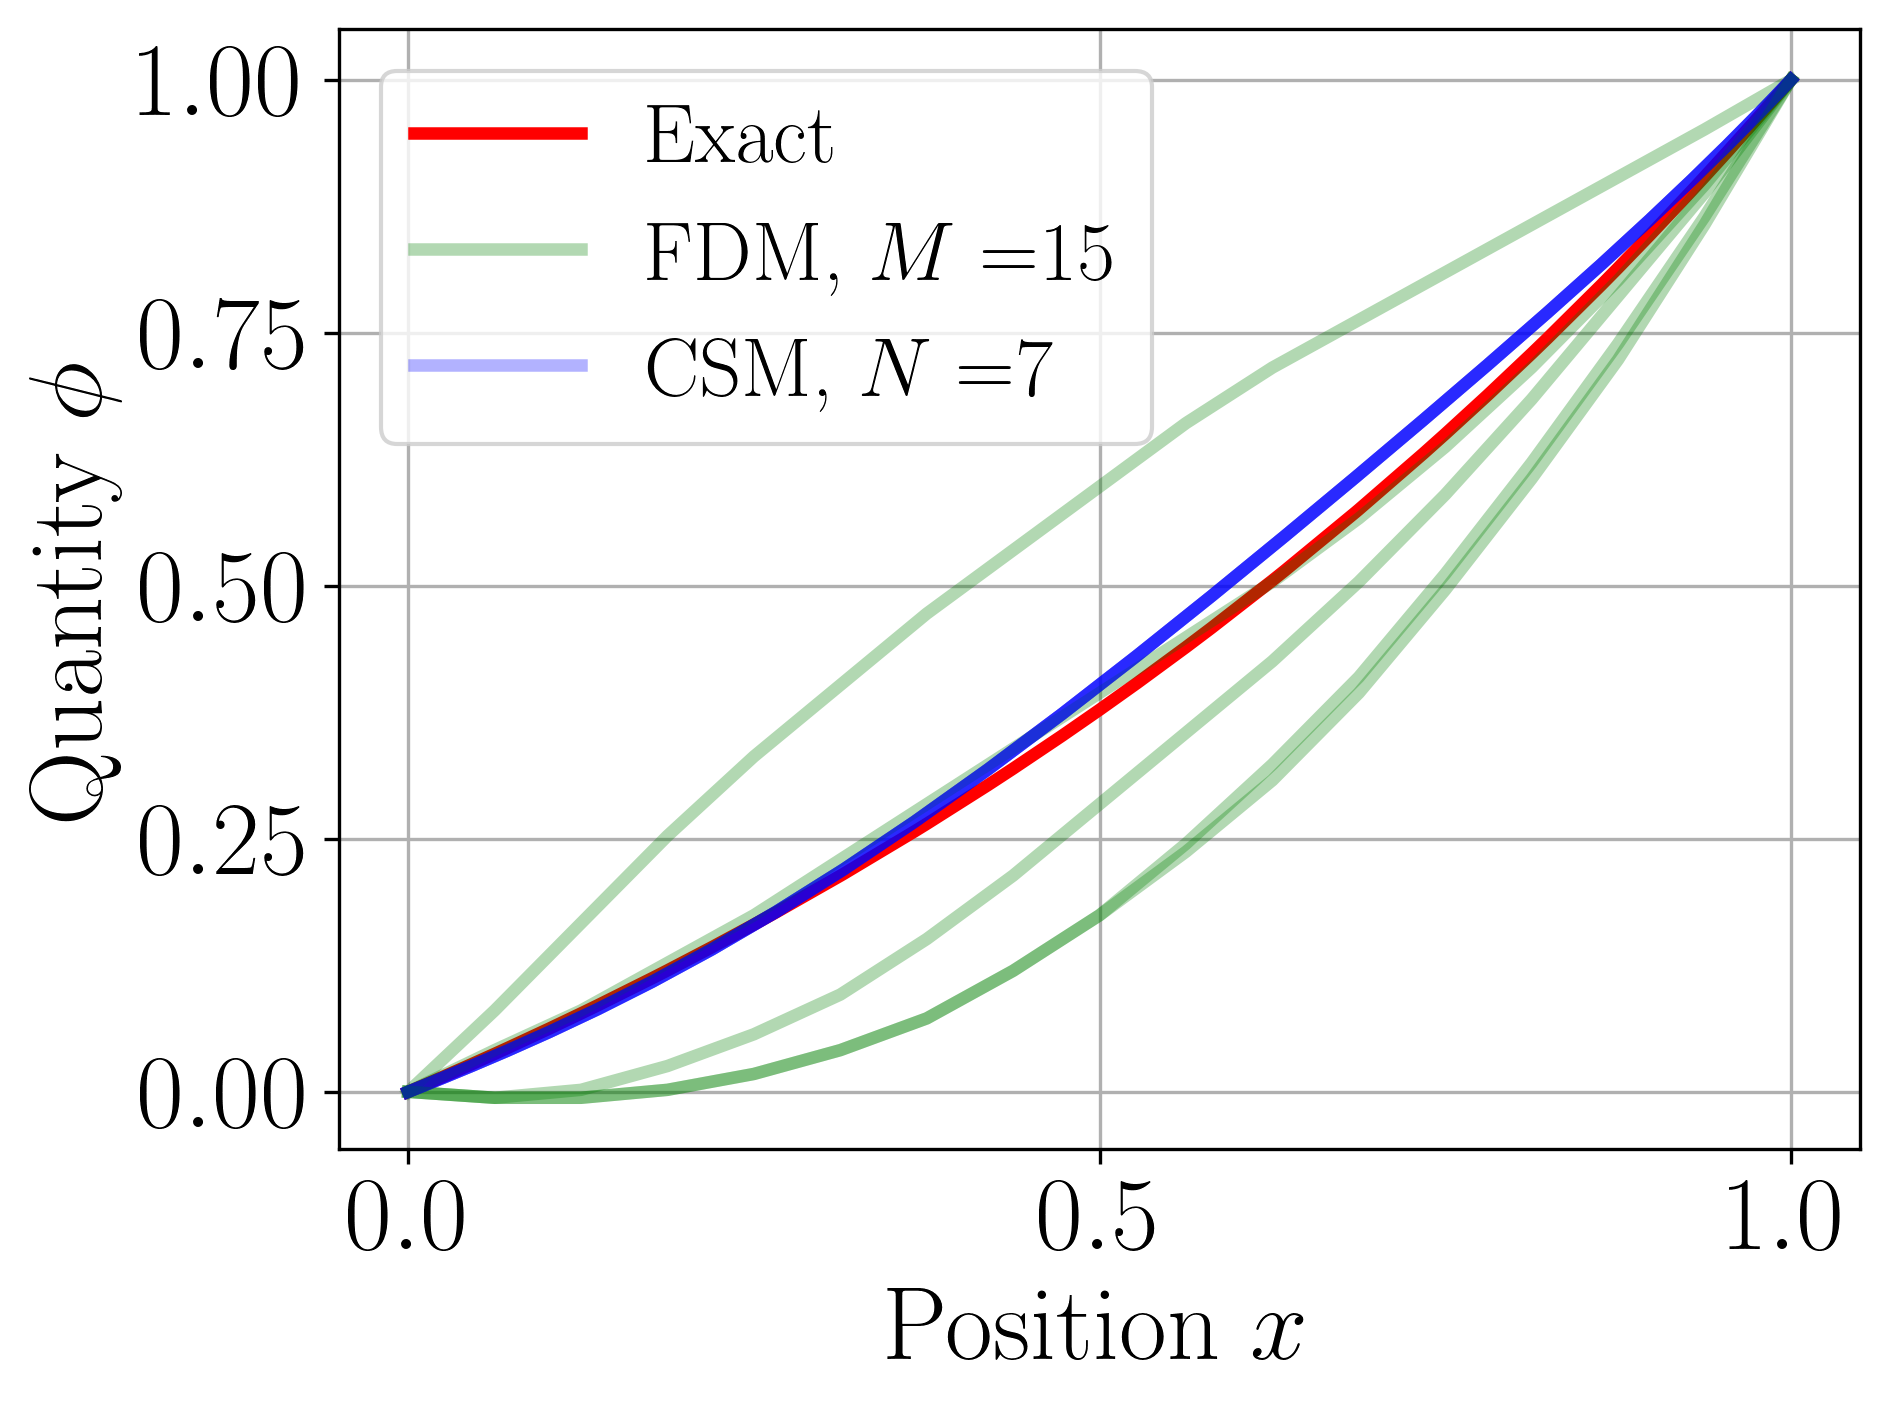

Error with FDM:  0.014934326647230605
Error with CSM:  0.00040603998532030134


In [18]:
#
# Visualization of the results
#

lw = 3
fs = 25
al = 0.3
fig,ax=plt.subplots(dpi=300)
# plt.rcParams["font.size"] = 18
cl=["red","green","blue","magenta","cyan"]
ll=["Exact",r"FDM, $M=$"+str(posM),r"CSM, $N=$"+str(posN+1)]
ax.grid()
ax.plot(eplotx, eploty, color=cl[0], label=ll[0], linewidth=lw)
for i in range(rep-1):
    ax.plot(xf, yf[i,:], color=cl[1], linewidth=lw, alpha=al)
    ax.plot(xc, yc[i,:], color=cl[2], linewidth=lw, alpha=al)
ax.plot(xf, yf[rep-1,:], color=cl[1], label=ll[1], linewidth=lw, alpha=al)
ax.plot(xc, yc[rep-1,:], color=cl[2], label=ll[2], linewidth=lw, alpha=al)

ax.legend(bbox_to_anchor=(0, 1),loc='upper left', fontsize =20)
# tit = r'Chebyshev-tau, $N=$ '+str(posN+1)+r', $n=$ '+str(n)
# ax.set_title(tit, fontsize =21)
# ax.text(0.05, 0.95,r"MSE$={0:.3f}e{1}$".format(totmse,ind), fontsize =30, backgroundcolor='white',verticalalignment='top', transform=ax.transAxes)
ax.set_xlabel(r'Position $x$',fontsize =fs)
ax.set_ylabel(r'Quantity $\phi$',fontsize =fs)
plt.tick_params(labelsize=fs)
fig.tight_layout()
plt.show()

print("Error with FDM: ",msef)
print("Error with CSM: ",msec)